# Assignment 1 - US Census data

This assignment is due on **September 6, 2017** at **11:59 pm**.

## Updates

* Added probability questions
* Added links to Dplyr resources

## Preliminaries

To work on this assignment, you will need three things:

1. Your basic [R installation with Jupyter and the Tidyverse](https://boisestate.github.io/CS533/resources.html).
2. The `censusapi` package, which can be installed with `conda install -c mdekstrand r-censusapi`.
3. A US Census API key, which you can obtain [here](https://api.census.gov/data/key_signup.html). Sometimes data sets will require you to register to get access to them, and this is a good exampe.

You can find documentation on the `censusapi` package in the [vignette](https://cran.r-project.org/web/packages/censusapi/vignettes/getting-started.html).

For reference, see [R for Data Science Chapter 5](r4ds.had.co.nz/transform.html) and the [dplyr introduction](dplyr.tidyverse.org/articles/dplyr.html).

In [1]:
library(tidyverse)
library(censusapi)
library(dplyr)
library(stringr)
library(ggplot2)
library(mapdata)
library(zipcode)
library("choroplethrMaps")
library("choroplethr")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: 'censusapi'

The following object is masked from 'package:methods':

    getFunction

Loading required package: maps

Attaching package: 'maps'

The following object is masked from 'package:purrr':

    map

Loading required package: acs
Loading required package: XML

Attaching package: 'acs'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:base':

    apply



Set up your census key:

In [2]:
Sys.setenv(CENSUS_KEY="816a29b6cfc0a0cffd5d6e158bf863277f30e5b7")

## Loading Census Data

The census data is scattered among a bunch of sources.  Accessing it is somewhat arcane.

- The `sf1` data set is the _summary file_, containing summary statistics about each region in the _decennial census_.
- The `vintage` says we want to use the 2010 census (the most recent one).
- `vars` selects some variables to download; `NAME` is the name of the region, `P0010001` is the total population, and `P0420002` is the total institutionalized (imprisoned) population.  For more fun, see the [full list of variables](http://api.census.gov/data/2010/sf1/variables.html).

In [3]:
last_census = getCensus(name="sf1", vintage=2010, vars=c("NAME", "P0010001", "P0420003","P0420004"), region="state:*")
head(last_census)

NAME,state,P0010001,P0420003,P0420004
Alabama,01,4779736,41177,1768
Alaska,02,710231,4206,515
Arizona,04,6392017,67767,2347
Arkansas,05,2915918,25844,2176
California,06,37253956,256807,18610
Colorado,08,5029196,40568,2645


In [4]:
last_census <- last_census %>% mutate(Prisoners = (P0420003 + P0420004))

I recommend that you rename the fields to be something more meaningful before proceeding!

In [5]:
names(last_census) <- c('Region', 'State_ID', 'Total_Population', 'Adult','Juvenile', 'Prison_Population') 

In [6]:
last_census <- last_census %>% select(Region, State_ID, Total_Population, Prison_Population)
head(last_census)

Region,State_ID,Total_Population,Prison_Population
Alabama,01,4779736,42945
Alaska,02,710231,4721
Arizona,04,6392017,70114
Arkansas,05,2915918,28020
California,06,37253956,275417
Colorado,08,5029196,43213


## Initial Questions

Write R code and text to answer the following questions:

### Most Populus States

- #### What 5 states have the highest population?

**Hint:** the `arrange` dplyr verb will sort data.

In [7]:
Ans <- arrange(last_census, desc(Total_Population)) %>% slice(1:5)

In [8]:
Ans

Region,State_ID,Total_Population,Prison_Population
California,06,37253956,275417
Texas,48,25145561,277313
New York,36,19378102,104455
Florida,12,18801310,177514
Illinois,17,12830632,75110


### Highest Prison Populations

- #### What 5 states have the highest prison populations?

In [9]:
Ans <- arrange(last_census, desc(Prison_Population))%>% slice(1:5)

In [10]:
Ans

Region,State_ID,Total_Population,Prison_Population
Texas,48,25145561,277313
California,06,37253956,275417
Florida,12,18801310,177514
Georgia,13,9687653,107979
Pennsylvania,42,12702379,106660


### Prisoners per Capita

- #### What 5 states have the most prisoners per capita?

In [11]:
last_census <- last_census %>% mutate(Prisoners_per_capita= (Prison_Population / Total_Population))

In [12]:
Ans <-arrange(last_census, desc(Prisoners_per_capita), Region) %>% slice(1:5)

In [13]:
Ans

Region,State_ID,Total_Population,Prison_Population,Prisoners_per_capita
Louisiana,22,4533372,62257,0.01373304
Mississippi,28,2967297,36520,0.01230750
Oklahoma,40,3751351,42113,0.01122609
Georgia,13,9687653,107979,0.01114604
Texas,48,25145561,277313,0.01102831


### Probability

- #### What is the probability that a person selected at random is born in Rhode Island?

In [14]:
total = sum(last_census$Total_Pop)

In [15]:
prob_person_rhodeisland <- function(x) {        
    #Pop<-last_census%>%select(Region, Total_Pop)%>%filter(Region==x)%>%select(Total_Pop)    
    pop <- last_census %>% filter(Region == x)
    prob = pop$Total_Pop/total
}

In [16]:
(prob_person_rhodeisland("Rhode Island"))

[1] 0.003368523

- #### What is the probability that a person is born in one of the Dakotas (North Dakota or South Dakota)?

In [17]:
BothDakotas <- last_census%>%filter(str_detect(Region, "Dakota"))

In [18]:
sum(BothDakotas$Total_Pop)/total

[1] 0.004758104

## Visualization

- #### Plot a histogram of state populations.

In [19]:
hist <- ggplot(data=last_census) +
geom_histogram(mapping = aes(x = Total_Population))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


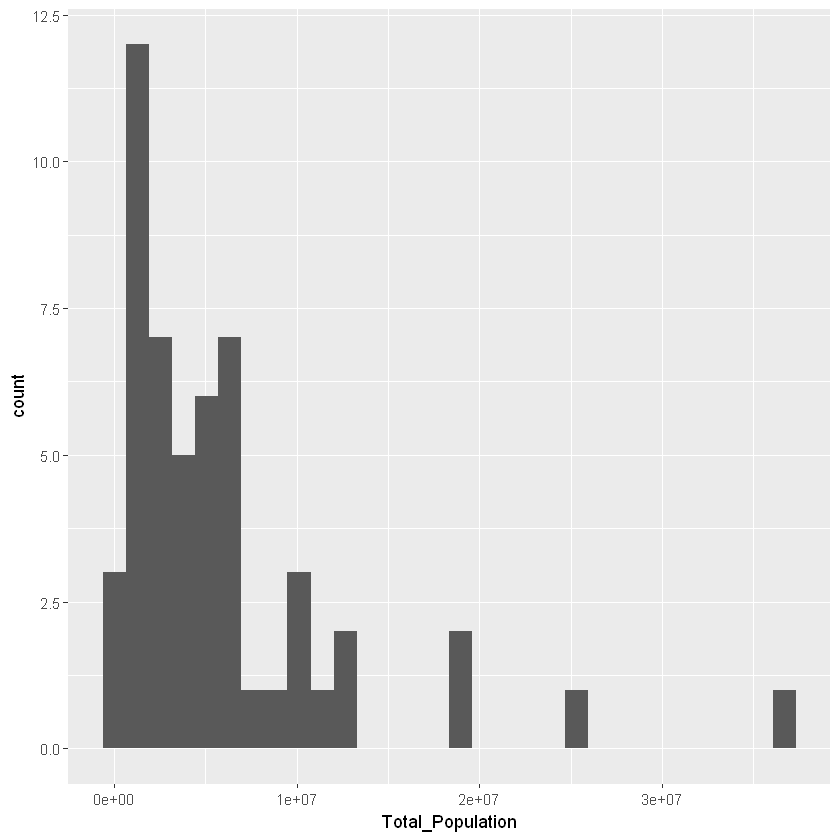

In [20]:
hist

- #### Plot a histogram of _county_ populations.  You can get counties by using `county:*` as your selector instead of `state:*` in a `getCensus` call.

In [21]:
county_population <- getCensus(name="sf1", vintage=2010, vars=c("NAME", "P0010001", "P0420003","P0420004"), region="county:*")

In [22]:
head(county_population)

NAME,state,county,P0010001,P0420003,P0420004
Autauga County,01,001,54571,181,0
Baldwin County,01,003,182265,1050,48
Barbour County,01,005,27457,3044,0
Bibb County,01,007,22915,2007,70
Blount County,01,009,57322,129,0
Bullock County,01,011,10914,1528,0


In [23]:
names(county_population) <- c('County', 'State_ID', 'County_ID' , 'Total_Population', 'Adult', 'Juvenile') #Renamed the fields
county_population <- county_population %>% mutate(Prison_Population = Adult + Juvenile)
head(county_population)

County,State_ID,County_ID,Total_Population,Adult,Juvenile,Prison_Population
Autauga County,01,001,54571,181,0,181
Baldwin County,01,003,182265,1050,48,1098
Barbour County,01,005,27457,3044,0,3044
Bibb County,01,007,22915,2007,70,2077
Blount County,01,009,57322,129,0,129
Bullock County,01,011,10914,1528,0,1528


In [24]:
hist <- ggplot(data = county_population) +
geom_histogram(mapping = aes(x = Total_Population))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


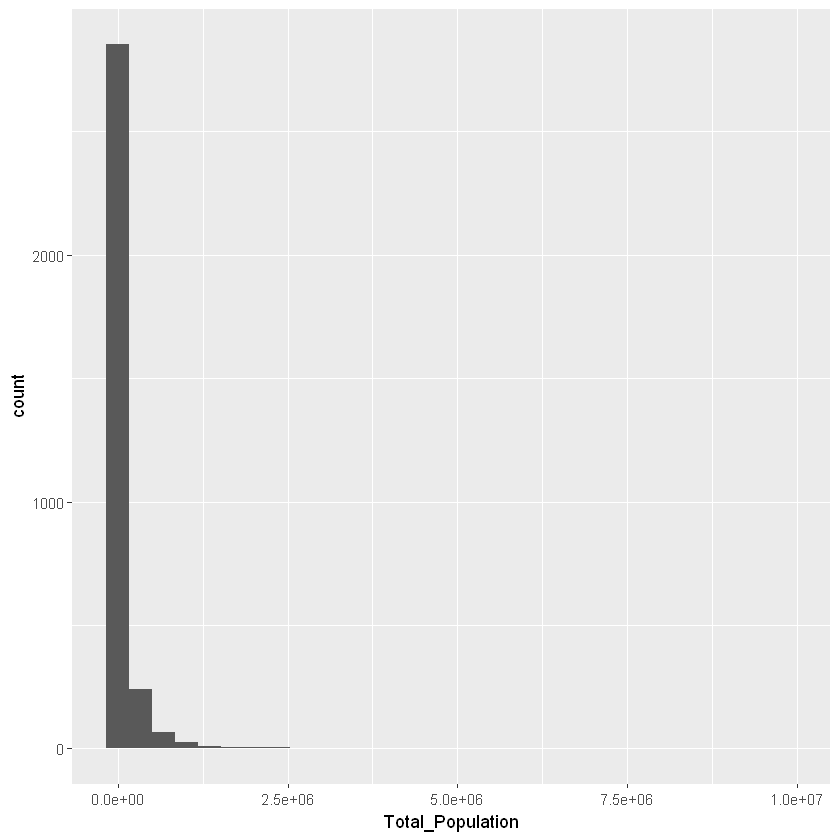

In [25]:
hist

- #### What are the largest 5 counties in Idaho?

In [26]:
Idaho_Counties <- county_population %>% filter(State_ID == 16) %>% select(County, Total_Population) %>% arrange(desc(Total_Population)) %>% slice(1:5)
Idaho_Counties

County,Total_Population
Ada County,392365
Canyon County,188923
Kootenai County,138494
Bonneville County,104234
Bannock County,82839


In [27]:
plot <- ggplot(Idaho_Counties, aes(x = County, y = Total_Population, fill = County)) +
geom_bar(stat = "identity",  width = 0.7) +
geom_text(aes(label = Total_Population), vjust = 1.8, size = 2.5, color = "white") +
theme_minimal() + guides(fill = FALSE)

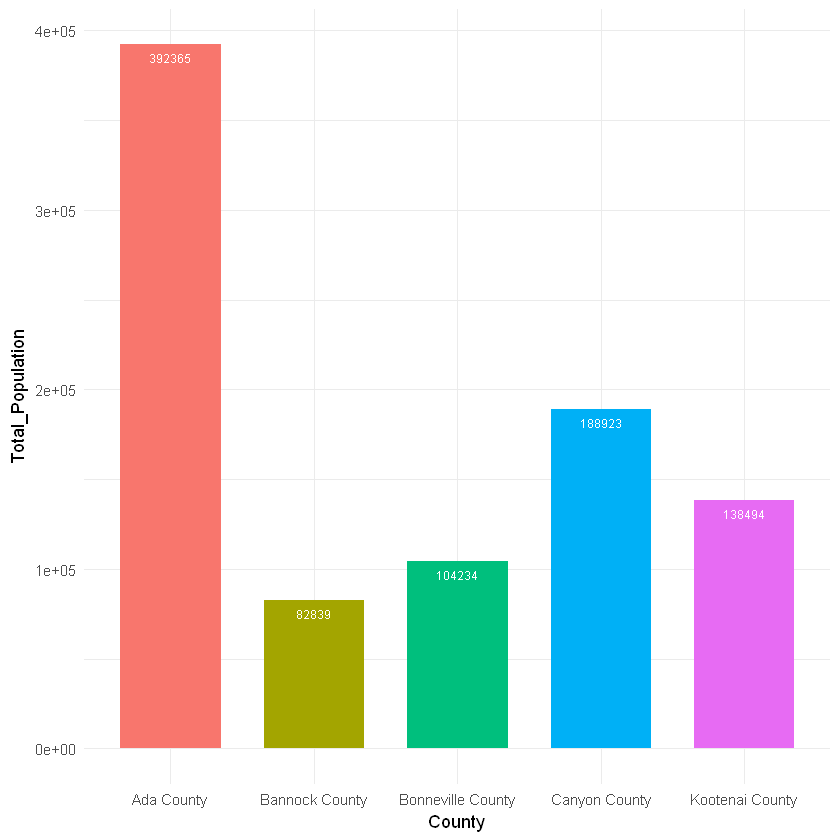

In [28]:
plot

## Joining Data

For the next section, we want to work with _two_ data sets.

Fetch the 2000 data set as well. Unfortunately, they changed the variable names!  You can find the 2000 list [here](http://api.census.gov/data/2000/sf1/variables.html); the key thing is that, for example, the total population variable is now `P001001`

In [29]:
past_census <- getCensus(name="sf1", vintage=2000, vars=c("NAME", "P001001"), region="state:*")
head(past_census)

NAME,state,P001001
Alabama,01,4447100
Alaska,02,626932
Arizona,04,5130632
Arkansas,05,2673400
California,06,33871648
Colorado,08,4301261


In [30]:
names(past_census) <- c("Region", "State_ID","Total_Population")

You will need to connect the two data sets; the `inner_join` dplyr verb is used for this.

In [31]:
total_census <- past_census %>% inner_join(last_census, by="State_ID")

In [32]:
names(total_census)

[1] "Region.x"             "State_ID"             "Total_Population.x"  
[4] "Region.y"             "Total_Population.y"   "Prison_Population"   
[7] "Prisoners_per_capita"

In [33]:
total_census <- total_census %>% select(Region.x, State_ID,Total_Population.x, Total_Population.y)

In [34]:
names(total_census) <- c("Region", "State_ID", "Population_2000", "Population_2010")

In [35]:
head(total_census)

Region,State_ID,Population_2000,Population_2010
Alabama,01,4447100,4779736
Alaska,02,626932,710231
Arizona,04,5130632,6392017
Arkansas,05,2673400,2915918
California,06,33871648,37253956
Colorado,08,4301261,5029196


### Population Growth

What 5 states saw the most population growth from 2000 to 2010?

In [36]:
total_census <- total_census %>% mutate(Population_Growth = (Population_2010 - Population_2000) / Population_2000)

In [37]:
Ans <- arrange(total_census, desc(Population_Growth)) %>% slice(1:5)

In [38]:
Ans

Region,State_ID,Population_2000,Population_2010,Population_Growth
Nevada,32,1998257,2700551,0.3514533
Arizona,04,5130632,6392017,0.2458537
Utah,49,2233169,2763885,0.2376515
Idaho,16,1293953,1567582,0.2114675
Texas,48,20851820,25145561,0.2059168


### Population Loss

What 5 states saw the most population loss from 2000 to 2010?

In [39]:
Ans <- arrange(total_census, (Population_Growth)) %>% slice(1:5)

In [40]:
Ans

Region,State_ID,Population_2000,Population_2010,Population_Growth
Michigan,26,9938444,9883640,-0.005514344
Rhode Island,44,1048319,1052567,0.004052202
Louisiana,22,4468976,4533372,0.014409565
Ohio,39,11353140,11536504,0.016150950
New York,36,18976457,19378102,0.021165437


### Fancy Graphics

See [Mapping US State, County, and Zipcode Data with R](http://www.poppy-zhang.com/r-coding/mapping-us-state-county-and-zipcode-data-with-r/) and plot a map of the 48 contiguous US states, shaded by their population growth from 2000 to 2010.

In [41]:
require(maps)
require(ggmap)

Loading required package: ggmap


In [42]:
total_census$state<-tolower(total_census$Region)

In [43]:
states <- map_data("state")
head(states)

long,lat,group,order,region,subregion
-87.46201,30.38968,1,1,alabama,NA
-87.48493,30.37249,1,2,alabama,NA
-87.52503,30.37249,1,3,alabama,NA
-87.53076,30.33239,1,4,alabama,NA
-87.57087,30.32665,1,5,alabama,NA
-87.58806,30.32665,1,6,alabama,NA


In [44]:
cnames<-aggregate(cbind(long,lat)~region, data=states, FUN=function(x)mean(range(x)))

In [45]:
head(cnames)

region,long,lat
alabama,-86.68851,32.62708
arizona,-111.92444,34.17407
arkansas,-92.13734,34.75275
california,-119.25830,37.27950
colorado,-105.55315,39.00124
connecticut,-72.75132,41.53085


In [46]:
plot<-ggplot(total_census, aes(map_id=state))+
geom_map(map=states, color ="black", aes(fill=Population_Growth))+
#geom_text(data=total_census, hjust=0.5, vjust=-0.5, aes(x=states$long, y=states$lat, label=state), color="white", size=4)+
#geom_label(data=cnames, aes(x=states$long, y=states$lat), colour="white", label=total_census$state, size=3)+
expand_limits(x=states$long, y=states$lat)+
scale_fill_gradient(low="white", high="red")+
labs(x=NULL, y=NULL)+
theme_classic()+
theme(panel.border = element_blank(), panel.background = element_blank(), axis.ticks = element_blank(), axis.text = element_blank())

In [47]:
options(repr.matrix.max.rows=20, repr.matrix.max.cols=10)
options(repr.plot.height=5)

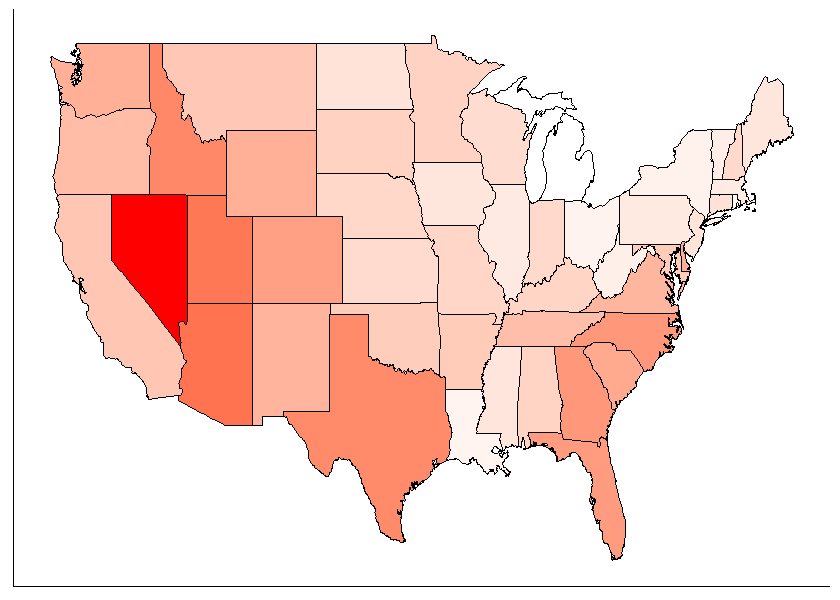

In [48]:
plot + guides(fill = FALSE)

## Go It Alone

Identify 5 more questions and answer them using the US Census data.

- At least one must use one or more variables not described above.
- At least 2 must involve joining more than one table
- You aren't restricted to state or even county level - individual census tracts can be interesting
- You do not need to keep looking nationwide - you can grab the census tracts in Idaho, for example

#### 1. What's the percentage distribution of four races (White, African-American, Hispanic/Latinos, Asian) in Idaho in 2010?

In [49]:
latest_census = getCensus(name="sf1", vintage=2010, vars=c("NAME", "P0080003", "P0080004", "P0090002", "P0080006"), region="state:*")

In [50]:
names(latest_census) <- c('State', 'Id', 'White', 'African_American', 'Hispanic_Latinos', 'Asian')
idaho_dist = latest_census %>% filter(State=="Idaho")
head(idaho_dist)

State,Id,White,African_American,Hispanic_Latinos,Asian
Idaho,16,1396487,9810,175901,19069


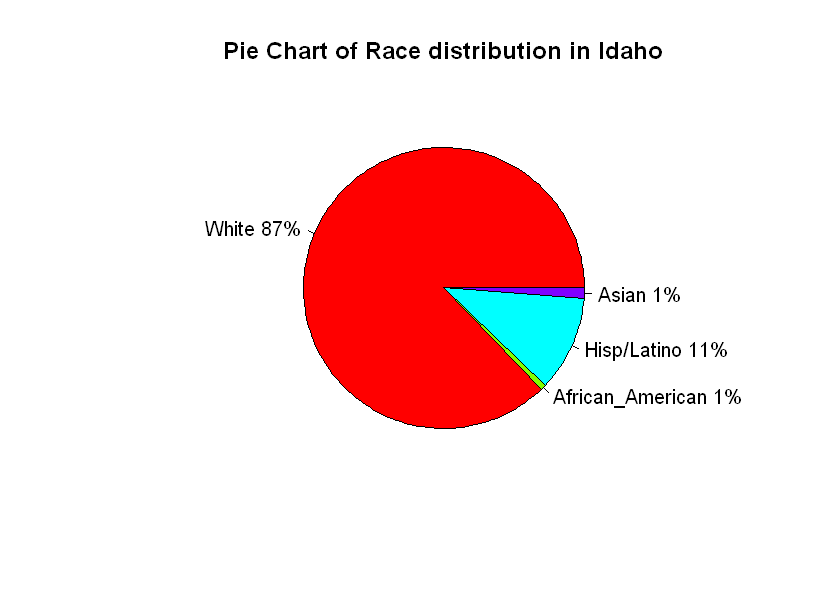

In [51]:
# Pie Chart with Percentages
slices <- c(idaho_dist$White, idaho_dist$African_American, idaho_dist$Hispanic_Latinos, idaho_dist$Asian) 
lbls <- c("White", "African_American", "Hisp/Latino", "Asian")
pct <- round(slices/sum(slices)*100)
lbls <- paste(lbls, pct) # add percents to labels 
lbls <- paste(lbls,"%",sep="") # ad % to labels 
pie(slices,labels = lbls, col=rainbow(length(lbls)), main="Pie Chart of Race distribution in Idaho")

#### 2. What's the change in percentage distribution of above races in Idaho from 2000 to 2010?

In [52]:
old_census = getCensus(name="sf1", vintage=2000, vars=c("NAME", "P003003", "P003004", "P004002", "P003006"), region="state:*")

In [53]:
names(latest_census)

[1] "State"            "Id"               "White"            "African_American"
[5] "Hispanic_Latinos" "Asian"

In [54]:
head(latest_census)

State,Id,White,African_American,Hispanic_Latinos,Asian
Alabama,01,3275394,1251311,185602,53595
Alaska,02,473576,23263,39249,38135
Arizona,04,4667121,259008,1895149,176695
Arkansas,05,2245229,449895,186050,36102
California,06,21453934,2299072,14013719,4861007
Colorado,08,4089202,201737,1038687,139028


In [55]:
names(old_census) <- c('State', 'Id', 'White', 'African_American', 'Hispanic_Latinos', 'Asian')
old_idaho_dist = old_census %>% filter(State=="Idaho")
latest_idaho_dist = latest_census %>% filter(Id==16)

names(latest_idaho_dist) <- c("NAME", "Id","White","African_American","Hispanic_Latinos","Asian")

compare_census <- old_idaho_dist %>% inner_join(latest_idaho_dist, by = "Id")

In [56]:
growth_census <- compare_census %>% 
mutate(Change_Percentage_White = ((White.y - White.x) / old_idaho_dist$White) * 100, 
      Change_Percentage_AA = ((African_American.y - African_American.x) / old_idaho_dist$African_American) * 100,
      Change_Percentage_HL = ((Hispanic_Latinos.y - Hispanic_Latinos.x) / old_idaho_dist$Hispanic_Latinos) * 100,
      Change_Percentage_Asian = ((Asian.y - Asian.x) / old_idaho_dist$Asian) * 100) %>% 
select(State, Change_Percentage_White, Change_Percentage_AA, Change_Percentage_HL, Change_Percentage_Asian)
head(growth_census)

State,Change_Percentage_White,Change_Percentage_AA,Change_Percentage_HL,Change_Percentage_Asian
Idaho,18.61737,79.80205,72.97768,60.39196


#### 3. Which state has highest proportion of people younger than 18?

In [57]:
young_population = getCensus(name = "sf1", vintage = 2010, vars = c("NAME", "P0010001", "P0100001"), region = "state:*")

In [58]:
names(young_population) <- c("state", "ID", "Total_Population", "Adult_Population")

In [59]:
young_population$Young_Population <- (young_population$Total_Population - young_population$Adult_Population)
young_population$Young_Proportion <- (young_population$Total_Population - young_population$Adult_Population) / young_population$Total_Population
#young_population$Old_Proportion<-(young_population$Adult_Population)/young_population$Total_Population

In [60]:
Ans <- arrange(young_population, desc(Young_Proportion)) %>% slice(1:5)

In [61]:
Ans

state,ID,Total_Population,Adult_Population,Young_Population,Young_Proportion
Utah,49,2763885,1892858,871027,0.3151459
Idaho,16,1567582,1138510,429072,0.2737158
Texas,48,25145561,18279737,6865824,0.2730432
Alaska,02,710231,522853,187378,0.2638268
Georgia,13,9687653,7196101,2491552,0.2571884


#### 4. Which were the 5 fastest growing Counties in the United States between 2000 and 2010?

In [62]:
county_census_2000 <- getCensus(name="sf1", vintage=2000, vars=c("NAME", "P001001"), region="county:*")
names(county_census_2000)<-c("County", "State_ID","County_ID", "Population")

county_census_2010 <- getCensus(name="sf1", vintage=2010, vars=c("NAME", "P0010001"), region="county:*")
names(county_census_2010)<-c("County", "State_ID","County_ID", "Population")

county_census_id_2000<-county_census_2000%>%filter(State_ID==16)
county_census_id_2010<-county_census_2010%>%filter(State_ID==16)

In [63]:
usa_county_dist <- county_census_2000 %>% inner_join(county_census_2010, by = c("County_ID","State_ID")) %>% inner_join(total_census %>% select(Region, State_ID), by = "State_ID")

In [64]:
usa_county_dist<-usa_county_dist%>%select(County.x, Region, Population.x, Population.y )

In [65]:
names(usa_county_dist)<-c("County", "State","Population_2000", "Population_2010")

In [66]:
usa_county_dist<-usa_county_dist%>%mutate(Population_difference=Population_2010-Population_2000, Percent_Change=100*(Population_2010-Population_2000)/Population_2000)

In [67]:
Ans<-arrange(usa_county_dist, desc(Percent_Change))%>%slice(1:5)

In [68]:
Ans

County,State,Population_2000,Population_2010,Population_difference,Percent_Change
Kendall County,Illinois,54544,114736,60192,110.35494
Pinal County,Arizona,179727,375770,196043,109.07821
Flagler County,Florida,49832,95696,45864,92.03725
Lincoln County,South Dakota,24131,44828,20697,85.76934
Loudoun County,Virginia,169599,312311,142712,84.14672


#### 5. What is the Population Change for the five Most Populous Counties in USA between 2000 and 2010?

In [69]:
Ans <- arrange(usa_county_dist, desc(Population_2010, Population_2000)) %>% slice(1:5)

In [70]:
Ans

County,State,Population_2000,Population_2010,Population_difference,Percent_Change
Los Angeles County,California,9519338,9818605,299267,3.143780
Cook County,Illinois,5376741,5194675,-182066,-3.386178
Harris County,Texas,3400578,4092459,691881,20.345982
Maricopa County,Arizona,3072149,3817117,744968,24.249084
San Diego County,California,2813833,3095313,281480,10.003437


#### 6. What is the Population Change for the five Most Populous Counties in Idaho between 2000 and 2010?

In [71]:
idaho_county_dist<-county_census_id_2000 %>% inner_join(county_census_id_2010, by="County_ID")

In [72]:
idaho_county_dist<-idaho_county_dist%>%select(County.x, State_ID.x, County_ID, Population.x, Population.y )
names(idaho_county_dist)<-c("County", "State_ID", "County_ID", "Population_2000", "Population_2010")

In [73]:
idaho_county_dist<-idaho_county_dist%>%mutate(Population_difference=Population_2010-Population_2000, Percent_Change=100*(Population_2010-Population_2000)/Population_2000)%>%select(County, Population_2000, Population_2010, Population_difference, Percent_Change)

In [74]:
Ans<-arrange(idaho_county_dist, desc(Population_2010, Population_2000))%>%slice(1:5)

In [75]:
Ans

County,Population_2000,Population_2010,Population_difference,Percent_Change
Ada County,300904,392365,91461,30.39541
Canyon County,131441,188923,57482,43.73217
Kootenai County,108685,138494,29809,27.42697
Bonneville County,82522,104234,21712,26.31056
Bannock County,75565,82839,7274,9.62615


## Submitting

Export your notebook to HTML and e-mail it to the professor.